###  Baseline Multimodal Model: Early Fusion (ResNet50 + DeBERTa)

This notebook establishes our baseline multimodal model for stance classification.

Architecture:
  - Text Branch:  DeBERTa
  - Image Branch: ResNet50 
  - Fusion:       Early Fusion (concatenate embeddings)
  - Classifier:   MLP

Strategy:
  - No data augmentation (raw data)
  - No gating mechanism (all images used)
  - Simple concatenation fusion
  - Standard hyperparameters

In [13]:
#Libraries
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score,confusion_matrix, classification_report
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModel,get_linear_schedule_with_warmup,AutoModelForSequenceClassification
from torchvision import models, transforms
from PIL import Image
import warnings
warnings.filterwarnings('ignore')


# Random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Seed:  {SEED}")
print(f"Using device: {DEVICE}")

Seed:  42
Using device: cuda


In [14]:
#Paths
DATA_PATH = "../../data/"
IMG_PATH = "../../data/images"
OUTPUT_DIR = "../../results/multimodal/baseline_multimodal/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

train_path = os.path.join(DATA_PATH,"train_augmented.csv")
dev_path   = os.path.join(DATA_PATH,"dev.csv")
test_path  = os.path.join(DATA_PATH,"test.csv")

#Load Data
df_train = pd.read_csv(train_path)
df_dev   = pd.read_csv(dev_path)
df_test  = pd.read_csv(test_path)

# Map labels to ints
stance_2id = {"oppose": 0, "support": 1}
pers_2id = {"no": 0, "yes": 1}

for df in [df_train, df_dev, df_test]:
    df["label"] = df["stance"].map(stance_2id)
    df["persuasiveness_label"] = df["persuasiveness"].map(pers_2id)


print(f"\n Train label distribution:")
print(f"\n Stance: \n Oppose: {(df_train['label']==0).sum()}\n Support: {(df_train['label']==1).sum()}")
print(f"\n\n  Persuasiveness \n No: {(df_train['persuasiveness_label']==0).sum()}\n Yes: {(df_train['persuasiveness_label']==1).sum()}")


df_train.head()


 Train label distribution:

 Stance: 
 Oppose: 1095
 Support: 1095


  Persuasiveness 
 No: 1548
 Yes: 642


,tweet_id,tweet_url,tweet_text,stance,persuasiveness,split,label,persuasiveness_label
0,1148501065308004357,https://t.co/VQP1FHaWAg,Let's McGyver some Sanity in America!\n\nYou a...,support,no,train,1,0
1,1103872992537276417,https://t.co/zsyXYSeBkp,A child deserves a chance at life. A child des...,oppose,no,train,0,0
2,1151528583623585794_aug,https://t.co/qSWvDX5MnM,"Dear prolifers: girls as young as 10, 11, 12 a...",support,no,train,1,0
3,1100166844026109953,https://t.co/hxH8tFIHUu,The many States will attempt to amend their co...,support,no,train,1,0
4,1021830413550067713,https://t.co/5whvEEtoQR,"Every #abortion is wrong, no matter what metho...",oppose,yes,train,0,1


In [15]:
#Models
TEXT_MODEL_NAME = "microsoft/deberta-v3-base"
VISION_MODEL_NAME = "resnet50"

In [16]:
 # Training hyperparameters
BATCH_SIZE = 16
NUM_EPOCHS = 15
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 1e-4
WARMUP_RATIO = 0.1

# Early stopping
PATIENCE = 5

# Image preprocessing
IMG_SIZE = 224
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

# Text preprocessing
MAX_TEXT_LENGTH = 105

# Other
NUM_WORKERS = 1
PIN_MEMORY = True if torch.cuda.is_available() else False
os.makedirs(OUTPUT_DIR, exist_ok=True)

###  Multimodal Dataset
We create a MultimodalDataset that will return:
- tokenized text (input_ids, attention_mask)
- image tensor (transforms applied)
- label (stance)

We will handle corrupted images safely (blank image).

In [17]:
image_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMG_MEAN, std=IMG_STD)
])

In [18]:
class MultimodalDataset(Dataset):
    """
    Dataset that returns (image, text, label) for multimodal learning.
    """
    
    def __init__(
        self,
        dataframe: pd.DataFrame,
        img_dir: str,
        tokenizer,
        image_transform,
        max_length: int = 128
    ):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.tokenizer = tokenizer
        self.image_transform = image_transform
        self.max_length = max_length
        

        # We calculate class distribution
        self.class_counts = self.df['label'].value_counts().to_dict()
        self.num_samples = len(self.df)

        print(f"  Dataset created: {self.num_samples} samples")
        print(f"    - Class 0 (oppose):  {self.class_counts.get(0, 0)} samples")
        print(f"    - Class 1 (support): {self.class_counts.get(1, 0)} samples")
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load Image
        img_path = os.path.join(self.img_dir, str(row['tweet_id']) + ".jpg")

        try:
            image = Image.open(img_path).convert('RGB')
            image = self.image_transform(image)
        except Exception as e:
            print(f"Warning: could not load image {img_path}. Using grey image instead.")
            image = Image.new("RGB", (224, 224), color=(128, 128, 128))
            image = self.image_transform(image)
        
        # Load Text and Tokenize 
        text = str(row['tweet_text'])
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Our Label
        label = row['label']
        
        return {
            'image': image,
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long),
            'tweet_id': str(row['tweet_id']),
            'text': text
        }
    
    #Attribute to calculate class weights
    def get_class_weights(self, device):
        num_class_0 = self.class_counts.get(0, 0)
        num_class_1 = self.class_counts.get(1, 0)
        total = self.num_samples
        
        weights = torch.tensor([
            total / num_class_0 if num_class_0 > 0 else 1.0,
            total / num_class_1 if num_class_1 > 0 else 1.0], dtype=torch.float32).to(device)
        return weights

In [19]:
# Load Tokenized
tokenizer = AutoTokenizer.from_pretrained(TEXT_MODEL_NAME)
print(f"Tokenizer loaded: {TEXT_MODEL_NAME}")

Tokenizer loaded: microsoft/deberta-v3-base


In [20]:
# Create datasets
train_dataset = MultimodalDataset(df_train, IMG_PATH, tokenizer, image_transforms, MAX_TEXT_LENGTH)
dev_dataset = MultimodalDataset(df_dev, IMG_PATH, tokenizer, image_transforms, MAX_TEXT_LENGTH)
test_dataset = MultimodalDataset(df_test, IMG_PATH, tokenizer, image_transforms, MAX_TEXT_LENGTH)


# Create dataloaders
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS,pin_memory=True)
dev_loader = DataLoader(dev_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS,pin_memory=True)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS,pin_memory=True)

  Dataset created: 2190 samples
    - Class 0 (oppose):  1095 samples
    - Class 1 (support): 1095 samples
  Dataset created: 200 samples
    - Class 0 (oppose):  127 samples
    - Class 1 (support): 73 samples
  Dataset created: 300 samples
    - Class 0 (oppose):  182 samples
    - Class 1 (support): 118 samples


In [21]:
#We test our datasets and loaders
sample = train_dataset[0]
print(f"  Image shape: {sample['image'].shape}")
print(f"  Input IDs shape: {sample['input_ids'].shape}")
print(f"  Label: {sample['label'].item()}")
print(f"  Text (truncated): {sample['text']}")

  Image shape: torch.Size([3, 224, 224])
  Input IDs shape: torch.Size([105])
  Label: 1
  Text (truncated): Let's McGyver some Sanity in America!

You are not pro-life if you lock children in cages, deny them lunch at school, or cut programs for the disabled!

And, good Christians don't applaud rapists, con men, &amp; hate!

Hate Fixes NADDA! It just creates more problems!

🧰📐🔎⛏️🔧🛠️🧰 https://t.co/VQP1FHaWAg


In [22]:
class MultimodalBaseline(nn.Module):
    def __init__(
        self,
        text_model_name="microsoft/deberta-v3-base",
        vision_model_name="resnet50",
        num_classes=2,
        freeze_text=False,
        freeze_vision=True
    ):
        super().__init__()

        # TEXT
        print(f"Loading TEXT encoder: {text_model_name}")
        self.text_encoder = AutoModel.from_pretrained(text_model_name)
        self.text_hidden = self.text_encoder.config.hidden_size

        if freeze_text:
            for p in self.text_encoder.parameters():
                p.requires_grad = False
            print("Text encoder FROZEN")

        # VISION
        print(f"Loading VISION encoder: {vision_model_name}")
        self.vision_encoder = models.resnet50(pretrained=True)
        self.vision_encoder = nn.Sequential(*list(self.vision_encoder.children())[:-1])
        self.vision_hidden = 2048

        if freeze_vision:
            for p in self.vision_encoder.parameters():
                p.requires_grad = False
            print("Vision encoder FROZEN")

        # We project our vision embeddings
        self.vision_proj = nn.Linear(self.vision_hidden, self.text_hidden)

        # CLASSIFIER
        self.classifier = nn.Linear(self.text_hidden * 2, num_classes)

        print("Multimodal baseline initialized.")

    def forward(self, input_ids, attention_mask, images=None, mode="multimodal"):
        
        # Text embeddings
        text_out = self.text_encoder(input_ids=input_ids,attention_mask=attention_mask)
        text_emb = text_out.last_hidden_state[:, 0, :]  # CLS

        # We add the Vision embeddings if Multimodal
        if mode == "multimodal" and images is not None:
            vision_feat = self.vision_encoder(images)
            vision_feat = vision_feat.squeeze(-1).squeeze(-1)
            vision_emb = self.vision_proj(vision_feat)
        else:
            vision_emb = torch.zeros_like(text_emb)

        # Early Fusion
        fused = torch.cat([text_emb, vision_emb], dim=1)
        logits = self.classifier(fused)

        return logits


#### Sanity Check (Forward)

In [23]:
model = MultimodalBaseline(
    text_model_name=TEXT_MODEL_NAME,
    num_classes=2,
    freeze_text=False,
    freeze_vision=True).to(DEVICE)

model.eval()
sample_batch = next(iter(train_loader))


with torch.no_grad():
    logits = model(
        input_ids=sample_batch["input_ids"][:2].to(DEVICE),
        attention_mask=sample_batch["attention_mask"][:2].to(DEVICE),
        images=sample_batch["image"][:2].to(DEVICE),
        mode="multimodal")


print("Logits shape:", logits.shape)

Loading TEXT encoder: microsoft/deberta-v3-base
Loading VISION encoder: resnet50
Vision encoder FROZEN
Multimodal baseline initialized.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Logits shape: torch.Size([2, 2])


In [24]:
model.eval()
batch = next(iter(train_loader))

input_ids = batch["input_ids"][:4].to(DEVICE)
attention_mask = batch["attention_mask"][:4].to(DEVICE)
images_real = batch["image"][:4].to(DEVICE)
images_zero = torch.zeros_like(images_real)

with torch.no_grad():
    logits_real = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        images=images_real,
        mode="multimodal"
    )

    logits_zero = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        images=images_zero,
        mode="multimodal"
    )

print("Δ logits (mean abs):",
      (logits_real - logits_zero).abs().mean().item())


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Δ logits (mean abs): 0.03902700915932655


### Training 

In [25]:
def train_text_only_model(
    model,
    train_loader,
    dev_loader,
    num_epochs=5,
    learning_rate=2e-5,
    patience=2,
    device=DEVICE):
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    best_f1 = 0.0
    best_model_state = None
    epochs_no_improve = 0

    history = {
        "train_loss": [],
        "train_f1": [],
        "dev_loss": [],
        "dev_f1": []
    }

    for epoch in range(num_epochs):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"{'='*60}")

        # Train
        model.train()
        train_loss = 0.0
        train_preds = []
        train_labels = []

        for batch in tqdm(train_loader, desc="Training"):
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            logits = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                mode="text_only"
            )

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * labels.size(0)

            preds = torch.argmax(logits, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_loss /= len(train_loader.dataset)
        train_f1 = f1_score(train_labels, train_preds, average="binary", pos_label=1)

        # Validation
        model.eval()
        dev_loss = 0.0
        dev_preds = []
        dev_labels = []

        with torch.no_grad():
            for batch in tqdm(dev_loader, desc="Validation", leave=False):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device)

                logits = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    mode="text_only"
                )

                loss = criterion(logits, labels)
                dev_loss += loss.item() * labels.size(0)

                preds = torch.argmax(logits, dim=1)
                dev_preds.extend(preds.cpu().numpy())
                dev_labels.extend(labels.cpu().numpy())

        dev_loss /= len(dev_loader.dataset)
        dev_f1 = f1_score(dev_labels, dev_preds, average="binary", pos_label=1)

        history["train_loss"].append(train_loss)
        history["train_f1"].append(train_f1)
        history["dev_loss"].append(dev_loss)
        history["dev_f1"].append(dev_f1)

        print(f"TRAIN → Loss: {train_loss:.4f} | F1: {train_f1:.4f}")
        print(f"DEV   → Loss: {dev_loss:.4f} | F1: {dev_f1:.4f}")

        # Early Stopping
        if dev_f1 > best_f1:
            best_f1 = dev_f1
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
            print(f" New best DEV F1: {best_f1:.4f}")
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epoch(s)")

            if epochs_no_improve >= patience:
                print(" Early stopping triggered")
                break

    model.load_state_dict(best_model_state)
    model = model.to(device)

    print(f"\nBest DEV F1: {best_f1:.4f}")
    return model, history

In [26]:
def train_multimodal_model(
    model, 
    train_loader, 
    dev_loader,
    num_epochs=15, 
    learning_rate=2e-5,
    weight_decay=1e-4, 
    warmup_ratio=0.1,
    mode="multimodal",
    patience=5, 
    device=DEVICE):
    
    model = model.to(device)

    # Class Weights (If data unblanced)
    class_weights = train_loader.dataset.get_class_weights(device)
    print(f"Class weights: oppose={class_weights[0]:.3f}, support={class_weights[1]:.3f}")

    # Loss
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # Optimizer
    optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate,weight_decay=weight_decay)

    # Scheduler 
    num_training_steps = len(train_loader) * num_epochs
    num_warmup_steps = int(num_training_steps * warmup_ratio)

    scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=num_warmup_steps,num_training_steps=num_training_steps)
    print(f"Total training steps: {num_training_steps}")
    print(f"Warmup steps: {num_warmup_steps}")

    #  History 
    history = {
        "train_loss": [],
        "train_f1": [],
        "dev_loss": [],
        "dev_f1": [],
        "learning_rates": []
    }

    #  Early stopping 
    best_f1 = 0.0
    best_model_state = None
    epochs_without_improvement = 0

    # OUR TRAINING LOOP
    for epoch in range(num_epochs):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"{'='*60}")

        # Train
        model.train()
        train_loss = 0.0
        train_preds = []
        train_labels = []

        for batch in tqdm(train_loader, desc="Training"):
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            images = batch["image"].to(device)
            labels = batch["label"].to(device)

            logits = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                images=images,
                mode=mode)

            loss = criterion(logits, labels)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            train_loss += loss.item() * labels.size(0)
            preds = torch.argmax(logits, dim=1)

            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_loss /= len(train_loader.dataset)
        train_f1 = f1_score(train_labels, train_preds, average="binary", pos_label=1)

        # Validation
        model.eval()
        dev_loss = 0.0
        dev_preds = []
        dev_labels = []

        with torch.no_grad():
            for batch in tqdm(dev_loader, desc="Validation", leave=False):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                images = batch["image"].to(device)
                labels = batch["label"].to(device)

                logits = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    images=images,
                    mode=mode)

                loss = criterion(logits, labels)
                dev_loss += loss.item() * labels.size(0)

                preds = torch.argmax(logits, dim=1)
                dev_preds.extend(preds.cpu().numpy())
                dev_labels.extend(labels.cpu().numpy())

        dev_loss /= len(dev_loader.dataset)
        dev_f1 = f1_score(dev_labels, dev_preds, average="binary", pos_label=1)

        current_lr = scheduler.get_last_lr()[0]

        history["train_loss"].append(train_loss)
        history["train_f1"].append(train_f1)
        history["dev_loss"].append(dev_loss)
        history["dev_f1"].append(dev_f1)
        history["learning_rates"].append(current_lr)

        print(f"TRAIN LOSS: {train_loss:.4f} | F1: {train_f1:.4f}")
        print(f"DEV LOSS: {dev_loss:.4f} | F1: {dev_f1:.4f}")
        print(f"LR: {current_lr:.2e}")

        # Early Stopping
        if dev_f1 > best_f1:
            best_f1 = dev_f1
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            epochs_without_improvement = 0
            print(f"  New best Dev F1: {best_f1:.4f}")
        else:
            epochs_without_improvement += 1
            print(f"No improvement for {epochs_without_improvement} epoch(s)")

            if epochs_without_improvement >= patience:
                print("\n  Early stopping triggered!")
                break

    # Load Best Model
    model.load_state_dict(best_model_state)
    model = model.to(device)

    print(f"\n{'='*60}")
    print(f"Training complete!")
    print(f"Best Dev F1 (pos=1): {best_f1:.4f}")
    print(f"{'='*60}")

    return model, history


In [27]:
print("TRAINING TEXT-ONLY MULTIMODAL BASELINE")

text_model = MultimodalBaseline(
    text_model_name=TEXT_MODEL_NAME,
    num_classes=2,
    freeze_text=False)

model_text, history_text = train_text_only_model(
    model=text_model,
    train_loader=train_loader,
    dev_loader=dev_loader,
    num_epochs=5,
    learning_rate=2e-5,
    patience=2,
    device=DEVICE)


TRAINING TEXT-ONLY MULTIMODAL BASELINE
Loading TEXT encoder: microsoft/deberta-v3-base
Loading VISION encoder: resnet50
Vision encoder FROZEN
Multimodal baseline initialized.

Epoch 1/5


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training:   0%|          | 0/137 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbbff4e9870>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


TRAIN → Loss: 0.4499 | F1: 0.7403
DEV   → Loss: 0.1965 | F1: 0.8841
 New best DEV F1: 0.8841

Epoch 2/5


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training:   0%|          | 0/137 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


TRAIN → Loss: 0.1926 | F1: 0.9255
DEV   → Loss: 0.2464 | F1: 0.8397
No improvement for 1 epoch(s)

Epoch 3/5


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training:   0%|          | 0/137 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


TRAIN → Loss: 0.1034 | F1: 0.9604
DEV   → Loss: 0.2102 | F1: 0.8828
No improvement for 2 epoch(s)
 Early stopping triggered

Best DEV F1: 0.8841


In [28]:
print("TRAINING MULTIMODAL MODEL")

model = MultimodalBaseline(
    text_model_name=TEXT_MODEL_NAME,
    num_classes=2,
    freeze_text=False,
    freeze_vision=True)

model, history = train_multimodal_model(
    model=model,
    train_loader=train_loader,
    dev_loader=dev_loader,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=WARMUP_RATIO,
    mode="multimodal",
    patience=PATIENCE,
    device=DEVICE
)
#model_save_path = os.path.join(OUTPUT_DIR, "multimodal_baseline_best.pth")
#torch.save(model.state_dict(), model_save_path)
#print(f"\nModel saved at: {model_save_path}")


TRAINING MULTIMODAL MODEL
Loading TEXT encoder: microsoft/deberta-v3-base
Loading VISION encoder: resnet50
Vision encoder FROZEN
Multimodal baseline initialized.
Class weights: oppose=2.000, support=2.000
Total training steps: 2055
Warmup steps: 205

Epoch 1/15


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training:   0%|          | 0/137 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbbff4e9870>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


TRAIN LOSS: 0.6208 | F1: 0.5400
DEV LOSS: 0.4754 | F1: 0.7097
LR: 1.34e-05
  New best Dev F1: 0.7097

Epoch 2/15


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training:   0%|          | 0/137 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


TRAIN LOSS: 0.2908 | F1: 0.8723
DEV LOSS: 0.2497 | F1: 0.8657
LR: 1.93e-05
  New best Dev F1: 0.8657

Epoch 3/15


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training:   0%|          | 0/137 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbbff4e9870>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


TRAIN LOSS: 0.1210 | F1: 0.9546
DEV LOSS: 0.3720 | F1: 0.8841
LR: 1.78e-05
  New best Dev F1: 0.8841

Epoch 4/15


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training:   0%|          | 0/137 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbbff4e9870>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


TRAIN LOSS: 0.0561 | F1: 0.9835
DEV LOSS: 0.4371 | F1: 0.8652
LR: 1.63e-05
No improvement for 1 epoch(s)

Epoch 5/15


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training:   0%|          | 0/137 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbbff4e9870>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


TRAIN LOSS: 0.0315 | F1: 0.9922
DEV LOSS: 0.4196 | F1: 0.9028
LR: 1.48e-05
  New best Dev F1: 0.9028

Epoch 6/15


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training:   0%|          | 0/137 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbbff4e9870>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Exception ignored in: huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbbff4e9870>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


TRAIN LOSS: 0.0203 | F1: 0.9931
DEV LOSS: 0.4234 | F1: 0.9000
LR: 1.33e-05
No improvement for 1 epoch(s)

Epoch 7/15


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training:   0%|          | 0/137 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbbff4e9870>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


TRAIN LOSS: 0.0096 | F1: 0.9982
DEV LOSS: 0.4040 | F1: 0.9014
LR: 1.18e-05
No improvement for 2 epoch(s)

Epoch 8/15


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training:   0%|          | 0/137 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbbff4e9870>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


TRAIN LOSS: 0.0130 | F1: 0.9959
DEV LOSS: 0.4610 | F1: 0.9118
LR: 1.04e-05
  New best Dev F1: 0.9118

Epoch 9/15


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training:   0%|          | 0/137 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbbff4e9870>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


TRAIN LOSS: 0.0072 | F1: 0.9986
DEV LOSS: 0.4223 | F1: 0.9078
LR: 8.89e-06
No improvement for 1 epoch(s)

Epoch 10/15


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training:   0%|          | 0/137 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbbff4e9870>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


TRAIN LOSS: 0.0045 | F1: 0.9986
DEV LOSS: 0.4650 | F1: 0.9078
LR: 7.41e-06
No improvement for 2 epoch(s)

Epoch 11/15


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training:   0%|          | 0/137 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbbff4e9870>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


TRAIN LOSS: 0.0052 | F1: 0.9982
DEV LOSS: 0.4801 | F1: 0.9078
LR: 5.92e-06
No improvement for 3 epoch(s)

Epoch 12/15


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training:   0%|          | 0/137 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbbff4e9870>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


TRAIN LOSS: 0.0031 | F1: 0.9986
DEV LOSS: 0.5099 | F1: 0.9078
LR: 4.44e-06
No improvement for 4 epoch(s)

Epoch 13/15


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training:   0%|          | 0/137 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbbff4e9870>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


TRAIN LOSS: 0.0014 | F1: 0.9995
DEV LOSS: 0.5426 | F1: 0.8806
LR: 2.96e-06
No improvement for 5 epoch(s)

  Early stopping triggered!

Training complete!
Best Dev F1 (pos=1): 0.9118


### Evaluation (Test Set)

In [29]:
def evaluate_model(model,dataloader,threshold=0.5,mode="multimodal",device="cuda",verbose=True):
    
    model.eval()
    all_labels = []
    all_probs = []
    all_preds = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", disable=not verbose):
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            images = batch["image"].to(device)


            #Text Only
            if mode=="text_only":
                logits = model(input_ids=input_ids,
                               attention_mask=attention_mask,
                               images=None,
                               mode=mode)
                
            #Multimodal
            else:
                logits = model(input_ids=input_ids,
                           attention_mask=attention_mask,
                           images=images,
                           mode=mode)

            probs = torch.softmax(logits, dim=1)[:, 1]
            preds = (probs >= threshold).long()

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Convert to numpy
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    y_prob = np.array(all_probs)

    # Metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="binary", pos_label=1)
    precision = precision_score(y_true, y_pred, average="binary", pos_label=1, zero_division=0)
    recall = recall_score(y_true, y_pred, average="binary", pos_label=1)
    cm = confusion_matrix(y_true, y_pred)

    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_prob': y_prob,
        'threshold': threshold
    }

    return results


In [31]:
print("TEXT MODEL - TEST RESULTS")
test_results = evaluate_model(model, test_loader, threshold=0.5, device=DEVICE, verbose=False,mode="text_only")
print(f"F1 Score:  {test_results['f1']:.4f}")
print(f"Precision: {test_results['precision']:.4f}")
print(f"Recall:    {test_results['recall']:.4f}")
print(f"Accuracy:  {test_results['accuracy']:.4f}")

MULTIMODAL MODEL - TEST RESULTS


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbbff4e9870>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-pack

F1 Score:  0.8352
Precision: 0.7622
Recall:    0.9237
Accuracy:  0.8567


In [33]:
print("MULTIMODAL MODEL - TEST RESULTS")
test_results = evaluate_model(model, test_loader, threshold=0.5, device=DEVICE, verbose=False,mode="multimodal")
print(f"F1 Score:  {test_results['f1']:.4f}")
print(f"Precision: {test_results['precision']:.4f}")
print(f"Recall:    {test_results['recall']:.4f}")
print(f"Accuracy:  {test_results['accuracy']:.4f}")

MULTIMODAL MODEL - TEST RESULTS


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


F1 Score:  0.8385
Precision: 0.7676
Recall:    0.9237
Accuracy:  0.8600


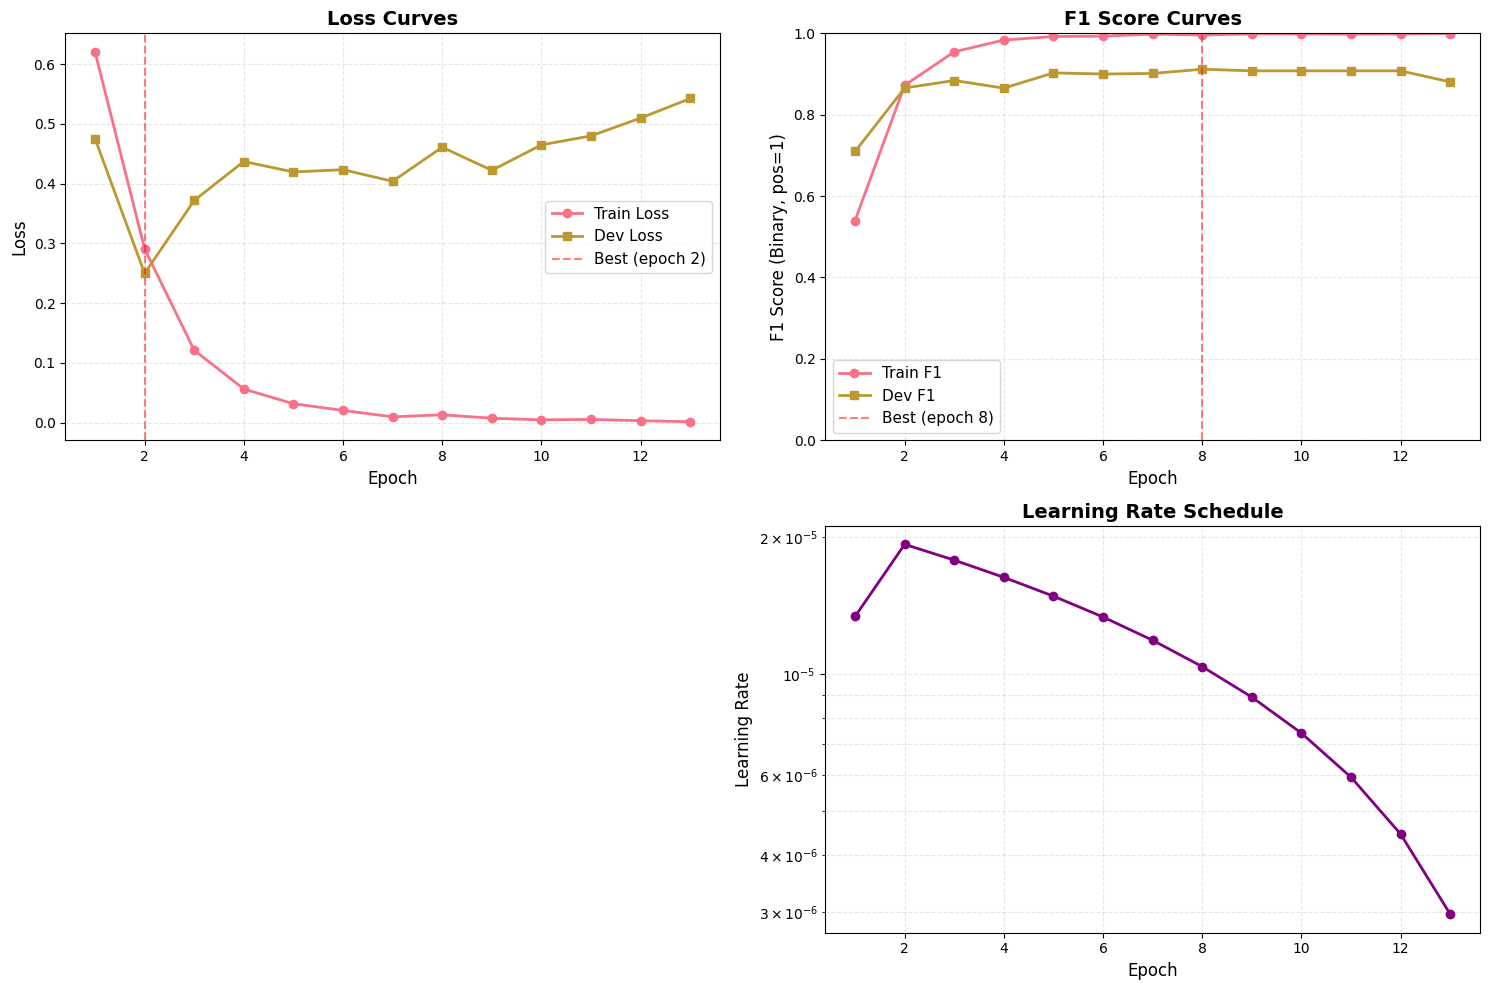

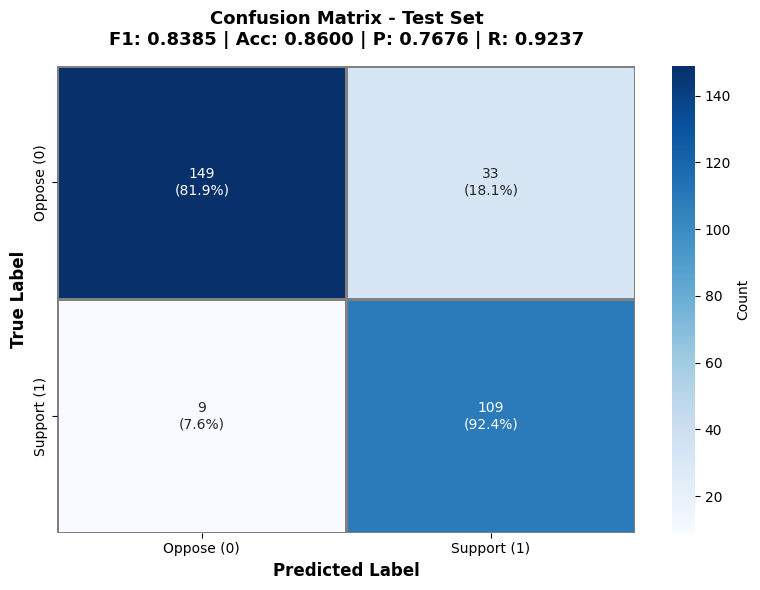

   FINAL RESULTS SUMMARY
Test Accuracy:  0.8600
Test Precision: 0.7676
Test Recall:    0.9237
Test F1 Score:  0.8385
All visualizations saved to: ../../results/multimodal/baseline_multimodal/


In [34]:
sns.set_palette("husl")

# Trainning Curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

epochs = range(1, len(history['train_loss']) + 1)

# Loss curves
axes[0, 0].plot(epochs, history['train_loss'], label='Train Loss', marker='o', linewidth=2)
axes[0, 0].plot(epochs, history['dev_loss'], label='Dev Loss', marker='s', linewidth=2)
axes[0, 0].set_title('Loss Curves', fontweight='bold', fontsize=14)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(alpha=0.3, linestyle='--')
# Best Epoch
best_epoch = np.argmin(history['dev_loss']) + 1
axes[0, 0].axvline(x=best_epoch, color='red', linestyle='--', alpha=0.5, label=f'Best (epoch {best_epoch})')
axes[0, 0].legend(fontsize=11)

# F1 curves
axes[0, 1].plot(epochs, history['train_f1'], label='Train F1', marker='o', linewidth=2)
axes[0, 1].plot(epochs, history['dev_f1'], label='Dev F1', marker='s', linewidth=2)
axes[0, 1].set_title('F1 Score Curves', fontweight='bold', fontsize=14)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('F1 Score (Binary, pos=1)', fontsize=12)
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(alpha=0.3, linestyle='--')
axes[0, 1].set_ylim([0, 1])  
# Best Epoch
best_epoch_f1 = np.argmax(history['dev_f1']) + 1
axes[0, 1].axvline(x=best_epoch_f1, color='red', linestyle='--', alpha=0.5, label=f'Best (epoch {best_epoch_f1})')
axes[0, 1].legend(fontsize=11)

# Precision & Recall curves 
if 'train_precision' in history and 'train_recall' in history:
    axes[1, 0].plot(epochs, history['train_precision'], label='Train Precision', marker='o', linewidth=2, alpha=0.7)
    axes[1, 0].plot(epochs, history['dev_precision'], label='Dev Precision', marker='s', linewidth=2, alpha=0.7)
    axes[1, 0].plot(epochs, history['train_recall'], label='Train Recall', marker='^', linewidth=2, alpha=0.7)
    axes[1, 0].plot(epochs, history['dev_recall'], label='Dev Recall', marker='v', linewidth=2, alpha=0.7)
    axes[1, 0].set_title('Precision & Recall', fontweight='bold', fontsize=14)
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('Score', fontsize=12)
    axes[1, 0].legend(fontsize=10, loc='best')
    axes[1, 0].grid(alpha=0.3, linestyle='--')
    axes[1, 0].set_ylim([0, 1])
else:
    if 'dev_threshold' in history:
        axes[1, 0].plot(epochs, history['dev_threshold'], label='Threshold', marker='o', color='green', linewidth=2)
        axes[1, 0].set_title('Optimal Threshold (Dev)', fontweight='bold', fontsize=14)
        axes[1, 0].set_xlabel('Epoch', fontsize=12)
        axes[1, 0].set_ylabel('Threshold', fontsize=12)
        axes[1, 0].legend(fontsize=11)
        axes[1, 0].grid(alpha=0.3, linestyle='--')
        axes[1, 0].set_ylim([0, 1])
    else:
        axes[1, 0].axis('off')

# Learning rate schedule
axes[1, 1].plot(epochs, history['learning_rates'], marker='o', color='purple', linewidth=2)
axes[1, 1].set_title('Learning Rate Schedule', fontweight='bold', fontsize=14)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Learning Rate', fontsize=12)
axes[1, 1].set_yscale('log')
axes[1, 1].grid(alpha=0.3, linestyle='--', which='both')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_curves.png'), dpi=300, bbox_inches='tight')
plt.show()


# Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))

cm = test_results['confusion_matrix']
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm,
            annot=np.array([[f"{count}\n({pct:.1%})" for count, pct in zip(row_counts, row_pcts)] 
                     for row_counts, row_pcts in zip(cm, cm_normalized)]),
    fmt='',
    cmap='Blues',
    xticklabels=['Oppose (0)', 'Support (1)'],
    yticklabels=['Oppose (0)', 'Support (1)'],
    ax=ax,
    cbar_kws={'label': 'Count'},
    linewidths=1,
    linecolor='gray'
)

ax.set_title(
    f'Confusion Matrix - Test Set\n'
    f'F1: {test_results["f1"]:.4f} | Acc: {test_results["accuracy"]:.4f} | '
    f'P: {test_results["precision"]:.4f} | R: {test_results["recall"]:.4f}',
    fontweight='bold', 
    fontsize=13,
    pad=15
)
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

# STATS
print(f"   FINAL RESULTS SUMMARY")
print(f"Test Accuracy:  {test_results['accuracy']:.4f}")
print(f"Test Precision: {test_results['precision']:.4f}")
print(f"Test Recall:    {test_results['recall']:.4f}")
print(f"Test F1 Score:  {test_results['f1']:.4f}")
print(f"All visualizations saved to: {OUTPUT_DIR}")